# Image compression with K-Means clustering

### Description:
We'll implement the K-means clustering algorithm and then use it to assign the $m\times m$ blocks of the given image in $k$ clusters and then replace each block with the respective centroid. Visually, the quality of the image does not deteriorate much for moderate $m$ and large enough $k$, while its size drops down significantly as we only have to store the $k$ centroids and the cluster allocations of the blocks


### Initialization

In [2]:
from PIL import Image
import requests
from io import BytesIO

url = "https://images.unsplash.com/photo-1611915387288-fd8d2f5f928b?ixlib=rb-4.0.3&w=1080&fit=max&q=80&fm=jpg&crop=entropy&cs=tinysrgb"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

In [3]:
import numpy as np
import torch
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

In [4]:
def to_patches(img: torch.Tensor, psize) -> np.ndarray:
  return img.unfold(1, size=psize, step=psize).unfold(2,size=m, step=m).flatten(1,2).permute(1,0,2,3).numpy()

def visualize_patches(patches: np.ndarray, true_image_size=512, padding=0) -> Image:
  patch_tensor = torch.from_numpy(patches)
  return Image.fromarray(
      make_grid(patch_tensor, nrow=true_image_size // patches.shape[2], padding=padding
                ).permute(1,2,0).mul(255).to(torch.uint8).numpy())

## 1. K-Means Clustering from scratch

In this part, we implement K-Means clustering algorithm for a dataset of points in $\mathbb{R}^n$. Including:

*   random centroid initialization (choose random dataset points)
*   distance function
      *   Implement private methods with different distance metric (Euclidean, $\ell_1$, cosine, etc.)
*   allocation of points to clusters for given centroids
*   centroids update based on distance to all data points in respective clusters
*   and, finally, implement K-Means fitting loop, wich returns new fitted centroids





### Task 1: Complete the code below

In [5]:
import random
import numpy as np
from scipy.spatial.distance import cdist, cosine

class KMeans:

  def __init__(
      self,
      num_clusters=1,
      num_features=1,
      max_iter=1000,
      epsilon=1e-6,
      dist_metric="euclidean"
    ) -> None:
    self.K = num_clusters
    self.C = num_features
    self.I = max_iter
    self.E = epsilon
    self.metric = dist_metric

  def init_centroids(self, X: np.ndarray) -> np.ndarray:
    """
    Initialize centroids in random manner
    """
    assert (self.C) == X.shape[1]
    centroids = np.zeros((self.K, self.C))
    centroids = X[np.random.choice(X.shape[0], self.K)]
    return centroids

  def dist(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Compute distance from each point to each centroid,
    depending on a self.metric type
    """
    distances = np.zeros((X.shape[0], centroids.shape[0]))
    
    if self.metric == "euclidean":

      for i in range(X.shape[0]):
        for j in range(centroids.shape[0]):
          dist = np.sqrt(np.sum((X[i] - centroids[j])**2))
          distances[i][j] = dist
          
    elif self.metric == "manhattan":

        for i in range(X.shape[0]):
          for j in range(centroids.shape[0]):
            dist = np.sum(np.abs(X[i] - centroids[j]))
            distances[i][j] = dist
            
    elif self.metric == "cosine":

      for i in range(X.shape[0]):
        for j in range(centroids.shape[0]):
          dist = 1 - np.dot(X[i], centroids[j]) / (np.linalg.norm(X[i]) * np.linalg.norm(centroids[j]))
          distances[i][j] = dist
      
    else:
      raise NotImplementedError(f"Unknown metric {self.metric}")
    return distances


  def calc_mask(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Compute distance between data and centroids, pick closest centroid for each
    data point.
    """
    return self.dist(X, centroids).argmin(-1)

  def update_clusters(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Compute new centroids, by computing the mean of each centroid's cluster.

    Hint: Beware, with high value of K, some clusters centroid's can become
    redundant, and have no points belonging to them.
    """
    mask = self.calc_mask(X, centroids)
    new_centroids = np.zeros_like(centroids)
    new_centroids = np.array([np.mean(X[mask == i], axis=0) if X[mask == i].shape[0] > 0 else centroids[i] for i in range(self.K)])
    return new_centroids

  def predict(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    mask = self.calc_mask(X, centroids)
    return centroids[mask]

  def fit(self, X: np.ndarray) -> np.ndarray:
    """
    Implement training loop that looks like this:
    -- initialize new centroids
    -- for max_iter steps:
      -- update centroids
      -- compute delta between old and new centroids
      -- return centroids if delta < epsilon

    """
    
    centroids = self.init_centroids(X)
    for _ in range(self.I):
      new_centroids = self.update_clusters(X, centroids)
      delta = np.abs(new_centroids - centroids)
      if (delta < self.E).all():
        break
      
      centroids = new_centroids
        
    return centroids

## 2. Image compression using K-Means clustering (0.5 pt)

The dataset for clustering will be the $m\times m$ patches of the initial image. We split the image into patches with helper function **to_patches()**

In [6]:
m = 16 # size of patch
img = img.resize((512,512))
img_tensor = ToTensor()(img) # 3, 512, 512

patches = to_patches(img_tensor, m)
patches.shape

(1024, 3, 16, 16)

Let's see how our splitted image looks:
(You can change padding from 0 to another value, to see the grid)

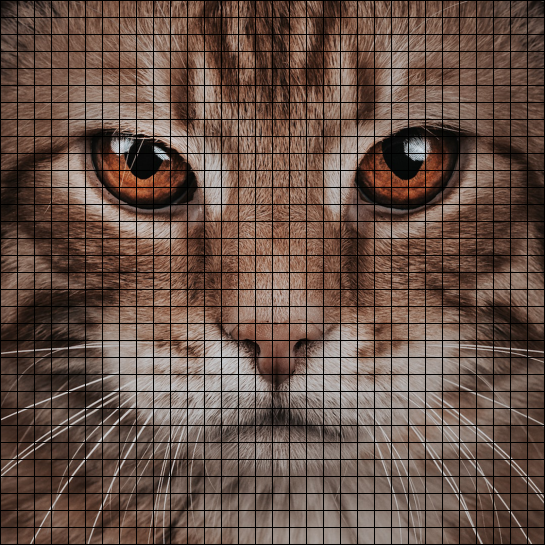

In [7]:
visualize_patches(patches, padding=1)

In [8]:
# convert patch data to feature vectors
data = patches.reshape(patches.shape[0], -1)
data.shape

(1024, 768)

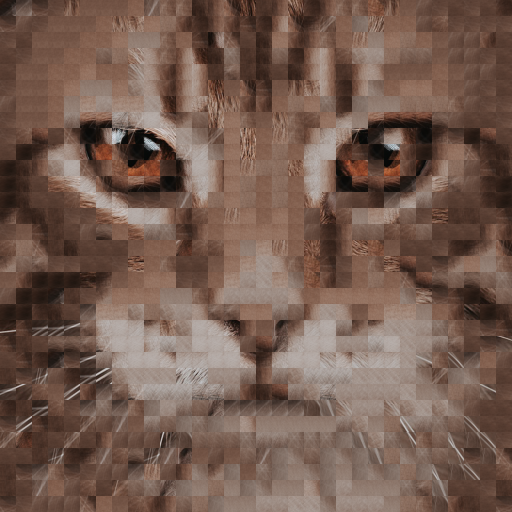

In [9]:
kmeans = KMeans(128, data.shape[-1], max_iter=400, dist_metric="euclidean")
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)

visualize_patches(predicted.reshape(-1,3,m,m))

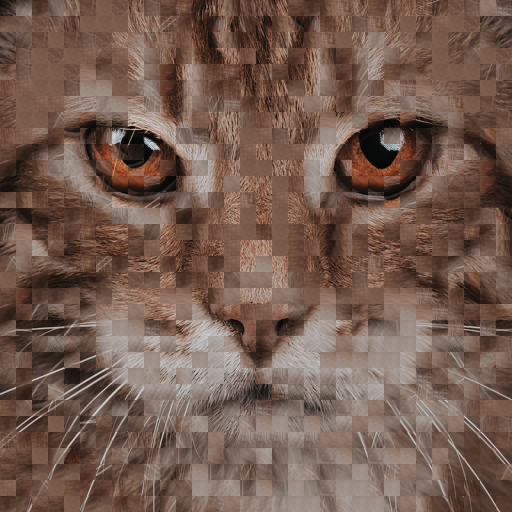

In [48]:
kmeans = KMeans(128, data.shape[-1], max_iter=400, dist_metric="cosine")
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)
visualize_patches(predicted.reshape(-1,3,m,m))

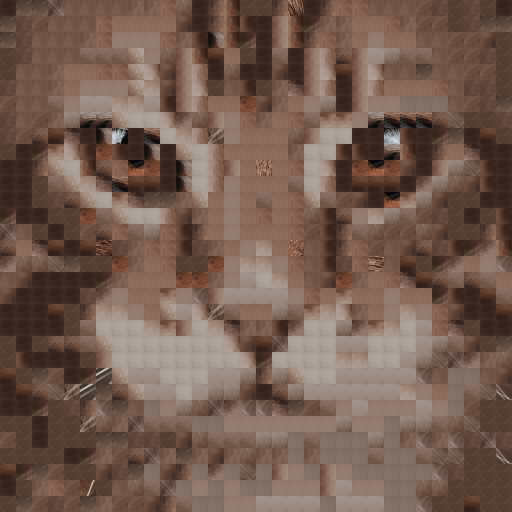

In [39]:
kmeans = KMeans(50, data.shape[-1], max_iter=400, dist_metric="manhattan")
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)
visualize_patches(predicted.reshape(-1,3,m,m))

In [46]:
for k in range(1, 33):
    compression_rate = round((1 - ((k * centroids.shape[1]) / (img_tensor.shape[0] * img_tensor.shape[1] * img_tensor.shape[2])))*100, 2)
    print(f"compression_rate in percentage: {compression_rate}% for k = {k}")


compression_rate in percentage: 99.9% for k = 1
compression_rate in percentage: 99.8% for k = 2
compression_rate in percentage: 99.71% for k = 3
compression_rate in percentage: 99.61% for k = 4
compression_rate in percentage: 99.51% for k = 5
compression_rate in percentage: 99.41% for k = 6
compression_rate in percentage: 99.32% for k = 7
compression_rate in percentage: 99.22% for k = 8
compression_rate in percentage: 99.12% for k = 9
compression_rate in percentage: 99.02% for k = 10
compression_rate in percentage: 98.93% for k = 11
compression_rate in percentage: 98.83% for k = 12
compression_rate in percentage: 98.73% for k = 13
compression_rate in percentage: 98.63% for k = 14
compression_rate in percentage: 98.54% for k = 15
compression_rate in percentage: 98.44% for k = 16
compression_rate in percentage: 98.34% for k = 17
compression_rate in percentage: 98.24% for k = 18
compression_rate in percentage: 98.14% for k = 19
compression_rate in percentage: 98.05% for k = 20
compression

As we can see from the compression rate above, our algorithm can compress picture in a drastic way. The trade off is the quality of the final picture. To be able to clearly recognize object on picture, it's enough to have at least 50 (93.16% rate of compression) clusters for `euclidean` and `manhattan`, and at least 100 (90.23% rate of compression) clusters for `cosine` distance.

### Results of the compression with 128 clusters and different distances

#### Results of the compression using Euclidean distance
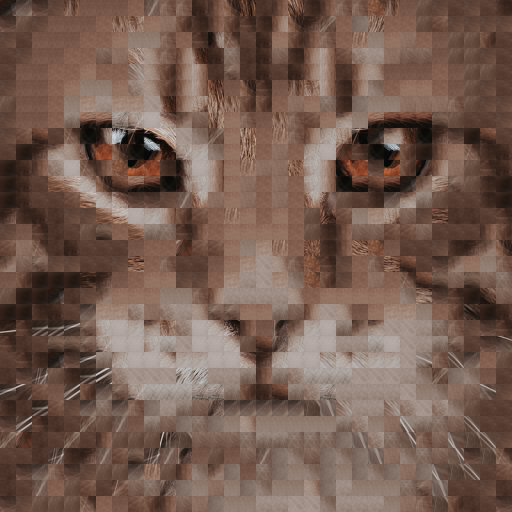

#### Results of the compression using Cosine distance
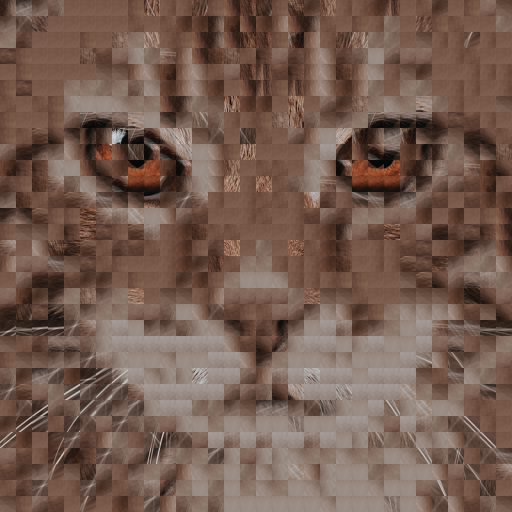

#### Results of the compression using Manhattan distance
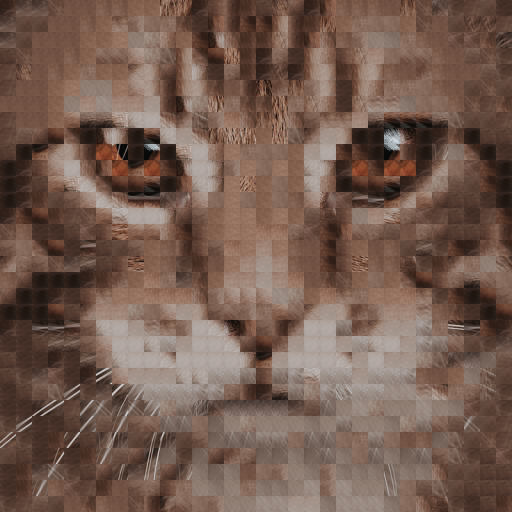

## 3. Elbow method 

In this task, we will use the Elbow method to visualize the trade-off between quality and number of clusters **k** and try to select the best one!

### Task 3: Implementation 
Here we will implement the calculation of **Distortion** or **Inertia**, which are basically squared distances from each point to its assigned centroid.

In [12]:
## For each k run clustering algorithm and compute it's Distortion value
def calc_distoriton(data: np.ndarray, centroids:np.ndarray) -> float:
    distortion = 0
    mask = kmeans.calc_mask(data, centroids)
    for i in range(data.shape[0]):
      distortion += np.sum((data[i] - centroids[mask[i]])**2)
    distortion = round(distortion, 2)
    return distortion

### Task 4: Calculate & Visualize (0.4 pt)
Let's use above implemented function to calculate distortion for some **k** values and visualize our results

In [13]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

In [14]:
k_min = 2
k_max = 200
k_range = range(k_min, k_max, 2)

dfs_list = list()
dist_metric = "euclidean"
dist_algorithms = ["euclidean", "manhattan", "cosine"]

for dist_algorithm in dist_algorithms:
  distortions = list()
  _temp_df = pd.DataFrame({'Clusters': k_range})
  _temp_df["distance_algorithm"] = dist_algorithm
  for k in k_range:

    kmeans = KMeans(k, data.shape[-1], max_iter=400, dist_metric=dist_algorithm)
    centroids = kmeans.fit(data)
    predicted = kmeans.predict(data, centroids)

    distortion = calc_distoriton(data, centroids)
    distortions.append(distortion)
  
  
  _temp_df.loc[_temp_df['distance_algorithm'] == dist_algorithm, 'Distortions'] = distortions
  dfs_list.append(_temp_df)
  
df = pd.concat(dfs_list)

fig = px.line(df, x='Clusters', y='Distortions', color="distance_algorithm").update_traces(mode='lines+markers')
fig.update_layout(title='Distortion vs. Number of Clusters', xaxis_title='Number of Clusters', yaxis_title='Distortion', legend_title_text="Distance Algorithm")
fig.show()

wall time: 30+min

---

The elbow method proves to be an effective and straightforward approach for determining the optimal number of clusters. This is evident from the graphs, where a decrease in distortion is observed as the number of clusters increases. However, beyond a specific cluster number, this decrease in distortion becomes much slower. By testing empirically we saw that the optimal number of clusters is around 100 for `euclidean` and `manhattan` distances, and around 150 for `cosine` distance. And those numbers coincide with the results we got from elbow method. Also, we can see that the `cosine` distance didn't converge to the same distortion as the other two distances. Thats why we have much more poor quality of the final picture for the same number of clusters using `cosine` distance.

Beyond the threshold of 100 clusters, the diminishing rate of distortion reduction becomes quite apparent. The marginal improvement in quality gained is tiny relative to the substantial increase in the number of clusters required to achieve it.

---

## 5. Bonus Problem
Besides compression, K-Means clustering can be used in more "creative" way -- using bigger patch sizes we can create cool "pop-art" mosaics :=)

In [69]:
m = 128 # size of patch
img = img.resize((512,512))
img_tensor = ToTensor()(img) # 3, 512, 512

patches = to_patches(img_tensor, m)
patches.shape

(16, 3, 128, 128)

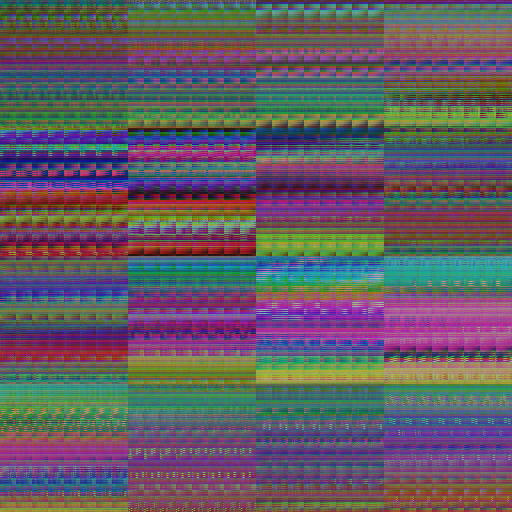

In [71]:
# initialize KMeans algo "cosine"
kmeans = KMeans(200, data.shape[-1], max_iter=400, dist_metric="euclidean")
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)
visualize_patches(predicted.reshape(-1,3,m,m))

For the task above we need to use bigger patch size, for example, 64x64 or 128x128, to achieve the picture close to mosaic.